In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv('../../cyberbullying/data/data.csv')
df.head()

,text,target
0,this is not creative those are the dictionar...,0.0
1,the term standard model is itself less npov...,0.0
2,true or false the situation as of march was...,0.0
3,next maybe you could work on being less conde...,0.0
4,this page will need disambiguation,0.0


In [3]:
df.shape

(230155, 2)

In [10]:
df_lem = pd.read_csv('../../cyberbullying/data/data_lem.csv')
df_lem.head()

,text,target
0,one make analogy mathematical terms envisionin...,0
1,clarification zundarks right checked wikipedia...,0
2,elected electoral jhk,0
3,fun entry devotchka coworker korea couldnt tel...,0
4,please relate ozone hole increases cancer prov...,0


In [11]:
df_lem.shape

(157203, 2)

In [12]:
def plot_dist(df):
    plt.figure(figsize = (7,7))
    sorted_counts = df['target'].value_counts()
    plt.pie(sorted_counts, labels = ['not bullying', 'bullying'], startangle = 90, counterclock = False,
            wedgeprops = {'width' : 0.6}, autopct='%1.1f%%', pctdistance = 0.7,
            textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = f'Total comments: {df.shape[0]}')
    plt.title('Distribution of Comments in the Dataset', fontsize = 16);

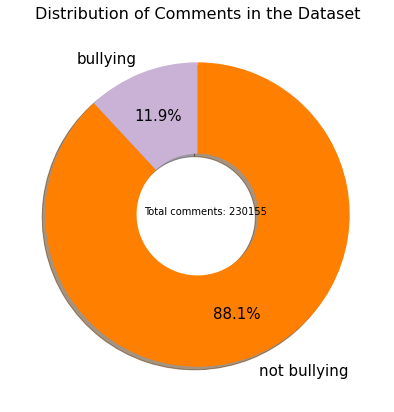

In [13]:
plot_dist(df)

In [82]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

In [167]:
df_lem[df_lem['target']==1]['text'][:10]

82        wasted bit sexuality havent read diatribe one ...
211       erik crying loud legally sex children underage...
245       boobs boobs boobs boobs boobs boobs boobs boob...
334                                     nazi filth impolite
483       prior quickpolls would permablocked guess ill ...
                                ...                        
157161    im soory since google images allowed ppl take ...
157162                   ever fuggin fag question know mine
157163    nice try cigaridiot explain odocoileus virgini...
157164    kys stylebackgroundcolor fdffe border px solid...
157166                  shut mind business go fuck one else
Name: text, Length: 15158, dtype: object

In [164]:
df_lem['text']

0         one make analogy mathematical terms envisionin...
1         clarification zundarks right checked wikipedia...
2                                     elected electoral jhk
3         fun entry devotchka coworker korea couldnt tel...
4         please relate ozone hole increases cancer prov...
                                ...                        
157198    sources dont exactly exude sense impartiality ...
157199    institute historical review peerreviewed journ...
157200    way youre trying describe article serious step...
157201    warning clearly protectionist regime going wit...
157202    alternate option perhaps enough newsworthy inf...
Name: text, Length: 157203, dtype: object

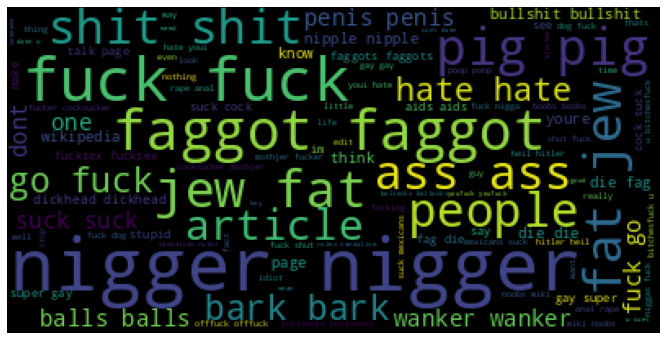

In [174]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(df_lem[df_lem['target']==1]['text'][:10000]))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


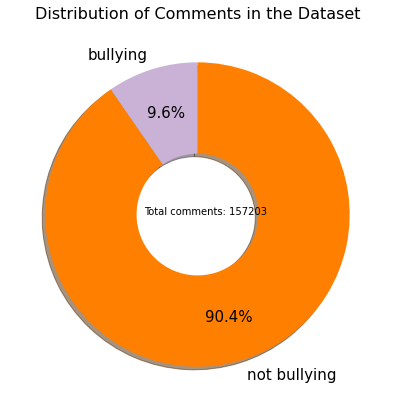

In [83]:
plot_dist(df_sample)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

In [86]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
X_train_vec = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
X_test_vec = count_vector.transform(X_test)

In [87]:
training_data = X_train_vec
testing_data = X_test_vec

In [117]:
def threshold_modifier(model,xtest,threshold):
    ypred=model.predict_proba(xtest)[:,1]>threshold
    ypred=ypred.astype(int)
    return ypred

In [114]:
def conf_mx_metrics(cm):
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1=(2*precision*recall)/(precision+recall)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {F1}")

In [118]:
def conf_mx_metrics2(cm):
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1=(2*precision*recall)/(precision+recall)
    
    return recall, precision, accuracy, F1

In [119]:
def best_threshold(thresholds_list,model,x_test,y_test):
    recalls=[]
    accuracies=[]
    precisions=[]
    F1_scores=[]
    for threshold in thresholds:
        y_pred=threshold_modifier(model,x_test,threshold)
        cm = confusion_matrix(y_test, y_pred)
        recall, precision, accuracy,F1_score=conf_mx_metrics2(cm)
        recalls.append(recall)
        accuracies.append(accuracy)
        precisions.append(precision)
        F1_scores.append(F1_score)     

    metrics={'thresholds': thresholds,'recall':recalls, 'accuracy': accuracies, 'precision':precisions,
             'F1_score':F1_scores}
    return metrics    

## SGDC Classiffier

In [150]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=15)),
    ('clf_sgd', SGDClassifier(validation_fraction=0.3,early_stopping=True,
                              alpha=0.0002,max_iter=2500,loss='log',
                              class_weight={0: 0.14, 1: 0.86}))])

# Set parameters to search
parameters = {'tfidf__max_df':(0.5,0.6,0.7,0.8,0.9,1)}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=1, scoring = "f1", cv=5)

grid_search.fit(X_train,y_train)
grid_search.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


CPU times: user 10.7 s, sys: 1.5 s, total: 12.2 s
Wall time: 1min 56s


0.6625107450759901

In [151]:
params=grid_search.best_params_
params

{'tfidf__max_df': 0.8}

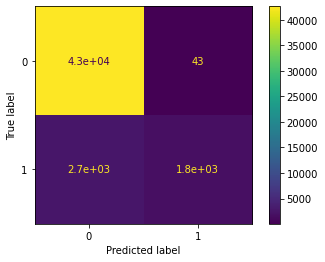

In [152]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot();


In [155]:
model=grid_search.best_estimator_


In [156]:
conf_mx_metrics(cm)

Recall: 0.397
Precision: 0.976
Accuracy: 0.942
F1 score: 0.5644166059723233


In [157]:
thresholds=np.arange(0.4,0.51,0.01)
best_thresholds=best_threshold(thresholds,model,X_test,y_test)

In [158]:
best_thresholds['thresholds']

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

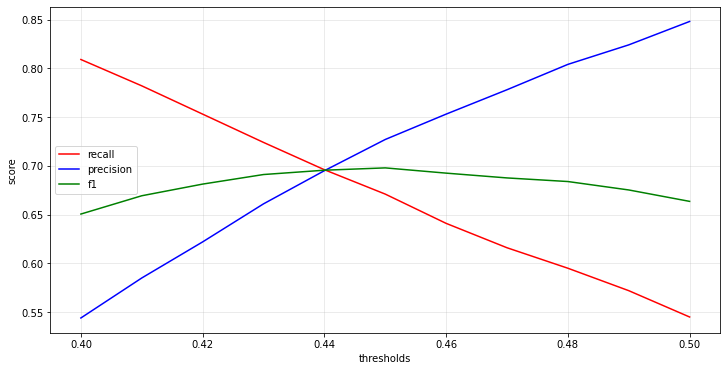

In [159]:
plt.figure(figsize=(12,6))
        
plt.plot(best_thresholds['thresholds'], best_thresholds['recall'], c='r', label='recall')
plt.plot(best_thresholds['thresholds'], best_thresholds['precision'], c='b', label='precision')    
plt.plot(best_thresholds['thresholds'], best_thresholds['F1_score'], c='g', label='f1')
plt.xlabel('thresholds')
plt.ylabel('score')
plt.legend()
plt.grid(alpha=0.3)
      


In [160]:
best_thresholds['F1_score'][5]

0.6978783977110157

In [161]:
best_thresholds['recall'][5]

0.671

In [162]:
best_thresholds['precision'][5]

0.727

/home/valengou/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/valengou/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/valengou/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 

In [ ]:
%%time
# Stochastic Gradient Descent
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

best_clf_sgd = param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

In [ ]:
%%time
# Decision Tree
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

best_clf_dt = param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

## Model analysis

In [13]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

In [14]:
# make a list of models
models = [MultinomialNB(),
          DecisionTreeClassifier(),
          LinearSVC(),
          AdaBoostClassifier(),
          RandomForestClassifier(),
          BaggingClassifier(),
          LogisticRegression(solver='liblinear'),
          SGDClassifier(),
          KNeighborsClassifier()
]

In [15]:
%%time
re = pipeline(models, X_train_vec, y_train, X_test_vec, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 13.49 sec
----------------------------------------------------
Training LinearSVC


/home/pjcopado/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training LinearSVC finished in 0.72 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 2.20 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 38.81 sec
----------------------------------------------------
Training BaggingClassifier
Training BaggingClassifier finished in 96.16 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 2.90 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.13 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------
CPU times: user 3min 12s, sys: 35.9 s, total: 3min 48s
Wall time: 3min 14s


In [16]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

In [17]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.949749,0.826590,0.617711,0.707046,0.004166,0.988822,0.992126,0.888746,0.937595,0.133759
1,LinearSVC,0.946498,0.765546,0.655868,0.706475,0.004302,0.999152,0.998709,0.992305,0.995497,0.721117
2,BaggingClassifier,0.944731,0.757859,0.642189,0.695246,0.642711,0.992336,0.990082,0.928182,0.958133,96.159988
3,RandomForestClassifier,0.950315,0.881960,0.570194,0.692610,4.211527,0.999879,1.000000,0.998718,0.999358,38.809098
4,LogisticRegression,0.948830,0.849632,0.581713,0.690598,0.005253,0.985611,0.991815,0.854761,0.918202,2.900531
5,DecisionTreeClassifier,0.937522,0.688856,0.663067,0.675715,0.070027,0.999970,1.000000,0.999679,0.999840,13.488327
6,MultinomialNB,0.942257,0.868557,0.485241,0.622633,0.009797,0.956107,0.832935,0.669766,0.742492,0.010524
7,AdaBoostClassifier,0.940066,0.875173,0.454284,0.598104,0.397985,0.943748,0.883820,0.465854,0.610120,2.199302
8,KNeighborsClassifier,0.921125,0.854545,0.236861,0.370913,34.846399,0.935357,0.928634,0.342097,0.500000,0.002271


In [18]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.921125,0.688856,0.236861,0.370913,0.004166,0.935357,0.832935,0.342097,0.50000,0.002271
max,0.950315,0.881960,0.663067,0.707046,34.846399,0.999970,1.000000,0.999679,0.99984,96.159988


In [19]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

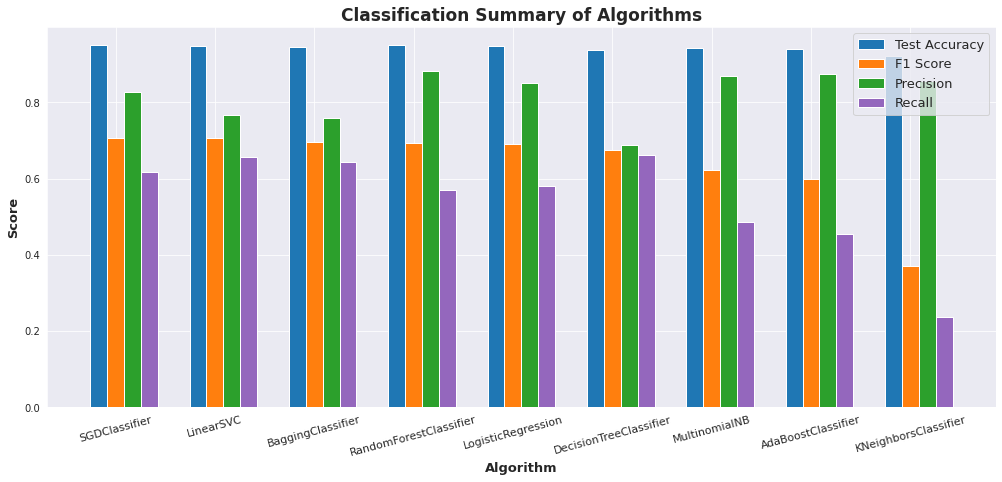

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9.2, 1, textstr, fontsize=14,
#        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [21]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

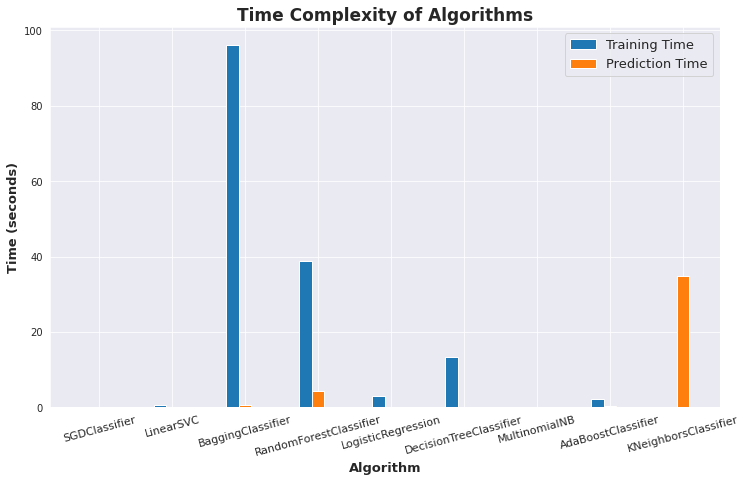

In [22]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

## Tunning Hyperparameters

In [23]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print(f"Best Parameters: {grid_fit.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, best_predictions):.4f}")
    print(f"F1-score: {f1_score(y_test, best_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, best_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, best_predictions):.4f}")
    
    return best_clf

In [24]:
%%time
# Stochastic Gradient Descent
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

best_clf_sgd = param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 2500}
Accuracy: 0.9500
F1-score: 0.6967
Precision: 0.8620
Recall: 0.5846
CPU times: user 14.7 s, sys: 41.5 s, total: 56.2 s
Wall time: 4.99 s


In [25]:
%%time
# Logistic Regression
param_grid = {
    'C': [1, 1.2, 1.3, 1.4]
}

clf_lr = LogisticRegression(solver='liblinear')

best_clf_lr = param_tuning(clf_lr, param_grid, training_data, y_train, testing_data, y_test)

/home/pjcopado/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression

Optimized Model
------
Best Parameters: {'C': 1.3}
Accuracy: 0.9490
F1-score: 0.6933
Precision: 0.8472
Recall: 0.5868
CPU times: user 3min 1s, sys: 9min 4s, total: 12min 6s
Wall time: 1min


In [26]:
%%time
# Decision Tree
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

best_clf_dt = param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 8}
Accuracy: 0.9414
F1-score: 0.6798
Precision: 0.7333
Recall: 0.6335
CPU times: user 8min 32s, sys: 607 ms, total: 8min 32s
Wall time: 8min 32s


In [29]:
%%time
# Random Forest Classifier
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

best_clf_rf = param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9488
F1-score: 0.6796
Precision: 0.8799
Recall: 0.5536
CPU times: user 42min 43s, sys: 0 ns, total: 42min 43s
Wall time: 42min 43s


In [49]:
%%time
# Linear SVC
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC(max_iter=10000, dual=True)

best_clf_linsvc = param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

/home/pjcopado/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC

Optimized Model
------
Best Parameters: {'C': 0.25}
Accuracy: 0.9490
F1-score: 0.7080
Precision: 0.8093
Recall: 0.6292
CPU times: user 2min 6s, sys: 0 ns, total: 2min 6s
Wall time: 2min 6s


In [50]:
X_train_vec

<33012x80684 sparse matrix of type '<class 'numpy.int64'>'
	with 906168 stored elements in Compressed Sparse Row format>

In [48]:
results_tunned = {'Model':[], 'Best Parameters':[], 'Accuracy':[], 'F1-score':[], 'Precision':[], 'Recall':[]}

for model in [best_clf_sgd, best_clf_lr, best_clf_dt, best_clf_rf, best_clf_linsvc]:
    best_predictions = model.predict(X_test_vec)
    results_tunned['Model'].append(model.__class__.__name__)
    results_tunned["Best Parameters"].append(model.get_params())
    results_tunned["Accuracy"].append(accuracy_score(y_test, best_predictions))
    results_tunned["F1-score"].append(f1_score(y_test, best_predictions))
    results_tunned["Precision"].append(precision_score(y_test, best_predictions))
    results_tunned["Recall"].append(recall_score(y_test, best_predictions))

#results_tunned
pd.DataFrame(results_tunned)

,Model,Best Parameters,Accuracy,F1-score,Precision,Recall
0,SGDClassifier,"{'alpha': 0.0002, 'average': False, 'class_wei...",0.950032,0.696697,0.861996,0.584593
1,LogisticRegression,"{'C': 1.3, 'class_weight': None, 'dual': False...",0.949042,0.693322,0.847193,0.586753
2,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.941409,0.679799,0.733333,0.633549
3,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.948760,0.679629,0.879863,0.553636
4,LinearSVC,"{'C': 0.25, 'class_weight': None, 'dual': True...",0.949042,0.707979,0.809259,0.629230
